# ML Training and Optimization

## Introduction

This notebook is dependent on the execution of `scripts/03 - data_preprocessing.py`

## Imports and Definitions

In [195]:
import pandas as pd
import sqlite3
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib
import yaml
import os

# ML imports
from sklearn.model_selection import train_test_split

print("Defining Classes")

class Logger:
    def __init__(self, config):
        self.config = config
        self.log_dir = config['logging']['out_dir']
        self.tag = config['base']['tag']
        self.file_path = os.path.join('outputs', self.tag, self.log_dir, 'log.txt')
        self.verbose = config['logging']['verbose']
        
    def log(self, message):
        current_datetime = datetime.datetime.now()
        datetime_string = current_datetime.strftime("%Y-%m-%d %H:%M:%S")
        log_message = f"{datetime_string}: {message}"
        if self.verbose:
            print(log_message)
        with open(self.file_path, "a") as f:
            f.write(f'{log_message}\n')

print("Defining Functions")

def loan_status_to_int(status):
    if status == 'Charged Off':
        return 0
    if status == 'Fully Paid':
        return 1
    else:
        return -1

def bestbandwidth(data):
    return 1.06*np.std(data)*len(data)**(-1/5)

def create_directory_if_not_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        return f"Created directory: {directory}"
    else:
        return f"Directory already exists: {directory}"

def transform_type(sqlite_type):
    if sqlite_type == 'INTEGER':
        return 'int'
    if sqlite_type == 'REAL':
        return 'float'
    if sqlite_type == 'TEXT':
        return 'object'

def map_dtype_to_sqlite(col_type):
    if col_type.startswith('int') or col_type == 'bool':
        return 'INTEGER'
    elif col_type.startswith('float'):
        return 'REAL'
    else:  # Default case, particularly for 'object' and other unhandled types
        return 'TEXT'

print("Reading Config File")

config_file_path = '../config/config.yml'

root_path = '..'

print(f"Reading Config File {config_file_path}")
with open(config_file_path, 'r') as f:
    config = yaml.safe_load(f)

print("Defining Variables and Creating Directories")

sqlite_file = config['data']['output_sqlite']

tag = config['base']['tag']

git_repo = config['base']['git_repo']

fontsize = config['plotting']['fontsize']
figsize_x = config['plotting']['figure_xsize']
figsize_y = config['plotting']['figure_ysize']

optimization_sample_size = config['machine_learning']['optimization_sample_size']

out_dir_figures = f"outputs/{tag}/figures"
out_dir_stats = f"outputs/{tag}/stats"
out_dir_log = f"outputs/{tag}/log"
out_dir_models = f"outputs/{tag}/models"

sqlite_file = os.path.join(f'{root_path}/outputs/{tag}/data/{sqlite_file}')
out_dir_figures = os.path.join(root_path, out_dir_figures)
out_dir_stats = os.path.join(root_path, out_dir_stats)
out_dir_log = os.path.join(root_path, out_dir_log)
out_dir_models = os.path.join(root_path, out_dir_log)

columns_of_interest = config['base']['columns_of_interest']

print("Done with initial setup")

Defining Classes
Defining Functions
Reading Config File
Reading Config File ../config/config.yml
Defining Variables and Creating Directories
Done with initial setup


## Loading Full and Sample Data

In [196]:
print("Loading Data")
# Defining the connection to the database
conn = sqlite3.connect(sqlite_file)

# Loading data into dataframe
data_fetch_query = f"""SELECT * 
                       FROM loans_data_ML
                       ORDER BY RANDOM()"""

loans_data = pd.read_sql_query(data_fetch_query, conn, index_col='id')

# Closing connection
conn.close()

print("Separating sample data for ML hyperparameter optimization, sample data will be balanced always, so will training data.")

sample_data = loans_data.sample(optimization_sample_size)

print("Done with Loading Full and Sample Data")

Loading Data
Separating sample data for ML hyperparameter optimization, sample data will be balanced always, so will training data.
Done with Loading Full and Sample Data


## Machine Learning Hyperparameter Optimization and Full Training

In [364]:
import sys
import os
import warnings

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    # Since we're setting this at the sys level, it should not be overridden
    os.environ["PYTHONWARNINGS"] = "ignore"  # Also affect subprocesses
   
X_opt, y_opt = sample_data.drop('loan_status', axis='columns').values, sample_data['loan_status'].values

X, y = balanced_loans_data.drop('loan_status', axis='columns').values, balanced_loans_data['loan_status'].values

ML_columns = balanced_loans_data.drop('loan_status', axis='columns').columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression

Through exploration we find that:
 - `solver = 'lbfgs'`
   - `C < 1e-6` causes an overfit, where the model only predicts defaults
   - Optimal `C` seems to be any value above 1e-5. giving around 56% accuracy.
 - `solver = 'liblinear'`
   - `l2` penalty is much faster than `l1`
   - Plateaus around `C 1e-2`, not much change if fitting time
   - Best accuract around ~65%
 - `solver = 'sag'`
   - 

In [23]:
cummulative_results = None

In [14]:
logistic_regression = LogisticRegression(class_weight='balanced', max_iter = 1000000)

scoring = {
    'accuracy': 'accuracy',  # Default scorer
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}

allowed_penalties = {
    'lbfgs': ['l2'],
    'liblinear': ['l2'],
    'newton-cg': ['l2']
}

for i, solver in enumerate(allowed_penalties.keys()):
    print(f"Optimizing for {solver} | {i}/{len(allowed_penalties.keys())}")
    param_grid = {
        'C': np.logspace(-10, 10, num = 50),
        'solver': [solver],
        'penalty': allowed_penalties[solver]
        }
    grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, verbose=10, scoring=scoring, refit='f1_score')

    grid_search.fit(X_opt, y_opt)

    clear_output(wait=True)

    results = pd.DataFrame(grid_search.cv_results_)
    results['ML_model'] = ["LogisticRegression"]*len(results)
    if cummulative_results is None:
        cummulative_results = results.copy()
    else:
        cummulative_results = pd.concat([cummulative_results, results])

for param in ['C', 'solver', 'penalty']:
    cummulative_results[f'param_{param}'] = [row['params'][param] for _, row in cummulative_results.iterrows()]

fig, ax = plt.subplots(5, figsize=[10, 25/1.62])

best_bw_time = bestbandwidth(cummulative_results['mean_fit_time'])
min_time, max_time = cummulative_results['mean_fit_time'].min(), cummulative_results['mean_fit_time'].max()
nBins_time = int((max_time - min_time)/best_bw_time)
bins_time = np.linspace(min_time, max_time, num = nBins_time)

for solver in cummulative_results['param_solver'].unique():
    for penalty in cummulative_results['param_penalty'].unique():
        label = f'Solver: {solver}, Penalty: {penalty}'
        mask_solver = cummulative_results['param_solver'].apply(lambda x: str(x) == solver)
        mask_panelty = cummulative_results['param_penalty'].apply(lambda x: str(x) == penalty)
        results_temp = cummulative_results[mask_solver & mask_panelty]
        
        Cs = results_temp['param_C']
        mean_scores = results_temp['mean_test_accuracy']
        std_scores = results_temp['std_test_accuracy']
        ax[0].errorbar(Cs, mean_scores, yerr=std_scores, fmt='o', label=label)
        ax[0].scatter(Cs, mean_scores, label=f'Penalty: {penalty}')

        mean_scores = results_temp['mean_test_precision']
        std_scores = results_temp['std_test_precision']
        ax[1].errorbar(Cs, mean_scores, yerr=std_scores, fmt='o', label=label)
        ax[1].scatter(Cs, mean_scores, label=f'Penalty: {penalty}')

        mean_scores = results_temp['mean_test_recall']
        std_scores = results_temp['std_test_recall']
        ax[2].errorbar(Cs, mean_scores, yerr=std_scores, fmt='o', label=label)
        ax[2].scatter(Cs, mean_scores, label=f'Penalty: {penalty}')

        mean_scores = results_temp['mean_test_f1_score']
        std_scores = results_temp['std_test_f1_score']
        ax[3].errorbar(Cs, mean_scores, yerr=std_scores, fmt='o', label=label)
        ax[3].scatter(Cs, mean_scores, label=f'Penalty: {penalty}')

        ax[4].hist(results_temp['mean_fit_time'], alpha=0.1, edgecolor = 'k', bins=bins_time, label=label)

        clear_output()

ax[0].set_xscale('log')
ax[0].set_xlabel('C (Inverse of Regularization Strength)')
ax[0].set_ylabel('Mean Accuracy Score')
ax[0].legend()

ax[1].set_xscale('log')
ax[1].set_xlabel('C (Inverse of Regularization Strength)')
ax[1].set_ylabel('Mean Precision Score')
ax[1].legend()

ax[2].set_xscale('log')
ax[2].set_xlabel('C (Inverse of Regularization Strength)')
ax[2].set_ylabel('Mean Recall Score')
ax[2].legend()

ax[3].set_xscale('log')
ax[3].set_xlabel('C (Inverse of Regularization Strength)')
ax[3].set_ylabel('Mean F1 Score')
ax[3].legend()

ax[4].set_xlabel("Fitting Time (s)")
ax[4].set_ylabel('Count')
ax[4].legend()

fig.tight_layout()

Optimizing for saga | 0/1
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START C=1e-10, penalty=l2, solver=saga..........................
[CV 1/5; 1/100] END C=1e-10, penalty=l2, solver=saga; accuracy: (test=0.540) f1_score: (test=0.346) precision: (test=0.241) recall: (test=0.612) total time=   9.7s
[CV 2/5; 1/100] START C=1e-10, penalty=l2, solver=saga..........................
[CV 2/5; 1/100] END C=1e-10, penalty=l2, solver=saga; accuracy: (test=0.509) f1_score: (test=0.353) precision: (test=0.239) recall: (test=0.675) total time=   8.0s
[CV 3/5; 1/100] START C=1e-10, penalty=l2, solver=saga..........................
[CV 3/5; 1/100] END C=1e-10, penalty=l2, solver=saga; accuracy: (test=0.534) f1_score: (test=0.358) precision: (test=0.247) recall: (test=0.654) total time=   8.0s
[CV 4/5; 1/100] START C=1e-10, penalty=l2, solver=saga..........................
[CV 4/5; 1/100] END C=1e-10, penalty=l2, solver=saga; accuracy: (test=0.508) f1_score: (test=0.

KeyboardInterrupt: 

In [18]:
cummulative_results = cummulative_results.replace('None', 'none')

In [25]:
cummulative_results.sort_values('mean_test_f1_score', inplace=True)
cummulative_results.dropna(inplace=True)
print("Loading best parameters and defining")
# Initialize the model
best_C = cummulative_results.iloc[-1]['param_C']
best_solver = cummulative_results.iloc[-1]['param_solver']
best_penalty = cummulative_results.iloc[-1]['param_penalty']

print(f"Best Parameters: \nC: {best_C}\nsolver: {best_solver}\npenalty {best_penalty}")
logistic_model = LogisticRegression(class_weight='balanced',
                                    max_iter=100000,
                                    C=best_C, 
                                    solver=best_solver,
                                    penalty=best_penalty)

print("Fitting the model to the training data")
# Train the model
logistic_model.fit(X_train, y_train)

print("Making predictions with the fit model")
# Make predictions
y_pred = logistic_model.predict(X_test)

print("Computing cross-validations")
train_sizes, train_scores, test_scores = learning_curve(
    logistic_model, X_train, y_train, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(.1, 1.0, 10),
    verbose=10)

print("Computing mean scores")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))

coefficients = np.abs(logistic_model.coef_[0])

# Combining feature names and their corresponding coefficients
features, coefs = zip(*sorted(zip(ML_columns, coefficients), key=lambda x: x[1], reverse=True))

features = np.array(features)
coefs = np.array(coefs)

features = features[coefs > 0]
coefs = coefs[coefs > 0]

print("Making Plots")
fig, ax = plt.subplots(1, 3, figsize = [20*1.62, 7.5])

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizing the confusion matrix

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_ylabel('Actual Labels')
ax[0].set_xlabel('Predicted Labels')

ax[1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax[1].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
ax[1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax[1].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax[1].set_title('Learning Curve')
ax[1].set_xlabel('Training Examples')
ax[1].set_ylabel('Score')
ax[1].legend(loc="best")


sns.barplot(x=coefs, y=features, edgecolor="black", ax=ax[2])
ax[2].set_title("Correlation between Loan status and Numeric Features")
ax[2].set_xlabel('Correlation')
ax[2].set_ylabel('Numerical Features')
ax[2].tick_params(axis='y', labelsize=5)

fig.tight_layout()

Loading best parameters and defining
Best Parameters: 
C: 0.2442053094548655
solver: newton-cg
penalty l2
Fitting the model to the training data
Making predictions with the fit model
Computing cross-validations
[learning_curve] Training set sizes: [ 86099 172199 258299 344399 430499 516598 602698 688798 774898 860998]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  50 | elapsed: 51.8min remaining: 811.0min
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed: 88.6min remaining: 403.6min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed: 111.9min remaining: 261.1min
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed: 137.6min remaining: 190.1min
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed: 153.9min remaining: 131.1min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed: 182.3min remaining: 93.9min
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed: 201.4min remaining: 56.8min


[CV] START .....................................................................
[CV] END ..................., score=(train=0.636, test=0.635) total time= 5.3min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.633, test=0.633) total time= 8.9min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.636, test=0.636) total time=20.1min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.636, test=0.634) total time=47.7min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.636, test=0.636) total time= 5.4min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.635, test=0.636) total time=18.8min
[CV] START .................

[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed: 232.8min remaining: 25.9min


[CV] START .....................................................................
[CV] END ..................., score=(train=0.636, test=0.635) total time=69.3min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.636, test=0.636) total time=34.4min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.636, test=0.637) total time=37.6min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.636, test=0.638) total time=33.9min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.636, test=0.635) total time=30.9min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.635, test=0.634) total time=22.9min
[CV] START .................

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 244.6min finished


Computing mean scores


NameError: name 'accuracy_score' is not defined

[CV] START .....................................................................
[CV] END ..................., score=(train=0.641, test=0.640) total time= 3.7min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.638, test=0.637) total time= 8.4min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.637, test=0.637) total time=24.4min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.636, test=0.635) total time=55.6min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.635, test=0.636) total time=30.4min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.635, test=0.636) total time=18.9min
[CV] START .................

In [32]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix


### Random Forest

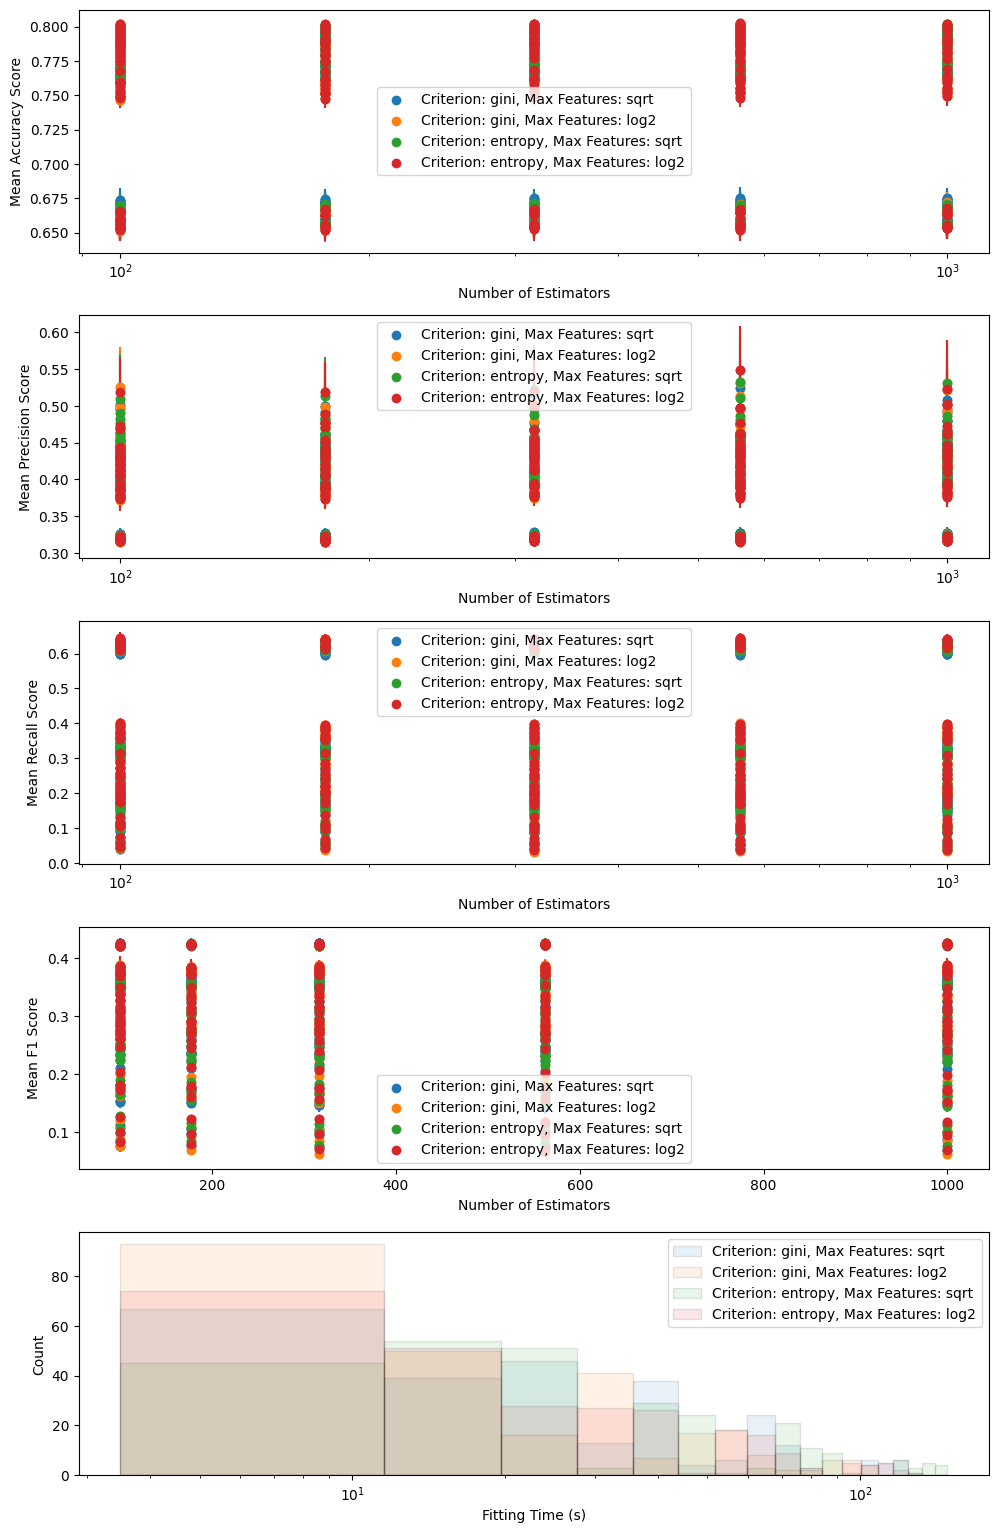

In [62]:
from sklearn.ensemble import RandomForestClassifier
    
random_forest_classifier = RandomForestClassifier(class_weight='balanced')

scoring = {
    'accuracy': 'accuracy',  # Default scorer
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}

param_grid = {
    'n_estimators': [int(i) for i in np.logspace(2, 3, 5)],  # Fewer, more spaced out values
    'criterion': ["gini", "entropy"],
    'max_features': ["sqrt", "log2"],  # Adding a fraction
    'max_depth': [None, 10, 30, 50],  # None means fully grown trees
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(random_forest_classifier,
                           param_grid,
                           cv=5,
                           verbose=10,
                           scoring=scoring,
                           refit='recall',
                           n_jobs=-1)

grid_search.fit(X_opt, y_opt)

clear_output(wait=True)

results = pd.DataFrame(grid_search.cv_results_)
results['ML_model'] = ["RandomForestClassifier"]*len(results)

for param in ['n_estimators', 'criterion', 'max_features']:
    results[f'param_{param}'] = [row['params'][param] for _, row in results.iterrows()]

if cummulative_results is None:
    cummulative_results = results.copy()
else:
    cummulative_results = pd.concat([cummulative_results, results])

fig, ax = plt.subplots(5, figsize=[10, 25/1.62])

best_bw_time = bestbandwidth(results['mean_fit_time'])
min_time, max_time = results['mean_fit_time'].min(), results['mean_fit_time'].max()
nBins_time = int((max_time - min_time)/best_bw_time)
bins_time = np.linspace(min_time, max_time, num = nBins_time)

for criterion in results['param_criterion'].dropna().unique():
    for max_features in results['param_max_features'].dropna().unique():
        label = f'Criterion: {criterion}, Max Features: {max_features}'
        mask_criterion = results['param_criterion'].apply(lambda x: str(x) == criterion)
        mask_max_features = results['param_max_features'].apply(lambda x: str(x) == max_features)
        results_temp = results[mask_criterion & mask_max_features].dropna()

        n_estimators = results_temp['param_n_estimators']
        mean_scores = results_temp['mean_test_accuracy']
        std_scores = results_temp['std_test_accuracy']
        ax[0].errorbar(n_estimators, mean_scores, yerr=std_scores, fmt='o')
        ax[0].scatter(n_estimators, mean_scores, label=label)

        mean_scores = results_temp['mean_test_precision']
        std_scores = results_temp['std_test_precision']
        ax[1].errorbar(n_estimators, mean_scores, yerr=std_scores, fmt='o')
        ax[1].scatter(n_estimators, mean_scores, label=label)

        mean_scores = results_temp['mean_test_recall']
        std_scores = results_temp['std_test_recall']
        ax[2].errorbar(n_estimators, mean_scores, yerr=std_scores, fmt='o')
        ax[2].scatter(n_estimators, mean_scores, label=label)

        mean_scores = results_temp['mean_test_f1_score']
        std_scores = results_temp['std_test_f1_score']
        ax[3].errorbar(n_estimators, mean_scores, yerr=std_scores, fmt='o')
        ax[3].scatter(n_estimators, mean_scores, label=label)

        ax[4].hist(results_temp['mean_fit_time'], alpha=0.1, edgecolor = 'k', bins=bins_time, label=label)

        clear_output()

ax[0].set_xscale('log')
ax[0].set_xlabel('Number of Estimators')
ax[0].set_ylabel('Mean Accuracy Score')
ax[0].legend()

ax[1].set_xscale('log')
ax[1].set_xlabel('Number of Estimators')
ax[1].set_ylabel('Mean Precision Score')
ax[1].legend()

ax[2].set_xscale('log')
ax[2].set_xlabel('Number of Estimators')
ax[2].set_ylabel('Mean Recall Score')
ax[2].legend()

ax[4].set_xscale('log')
ax[3].set_xlabel('Number of Estimators')
ax[3].set_ylabel('Mean F1 Score')
ax[3].legend()

ax[4].set_xlabel("Fitting Time (s)")
ax[4].set_ylabel('Count')
ax[4].legend()

fig.tight_layout()

Loading best parameters and defining
Best Parameters: 
 - N Estimators: 100
 - Criterion: entropy
 - Max_Features log2
Fitting the model to the training data
Making predictions with the fit model
Computing mean scores
Accuracy: 0.6315533222825965
              precision    recall  f1-score   support

           0       0.89      0.62      0.73    215639
           1       0.31      0.68      0.42     53423

    accuracy                           0.63    269062
   macro avg       0.60      0.65      0.58    269062
weighted avg       0.77      0.63      0.67    269062

Making Plots


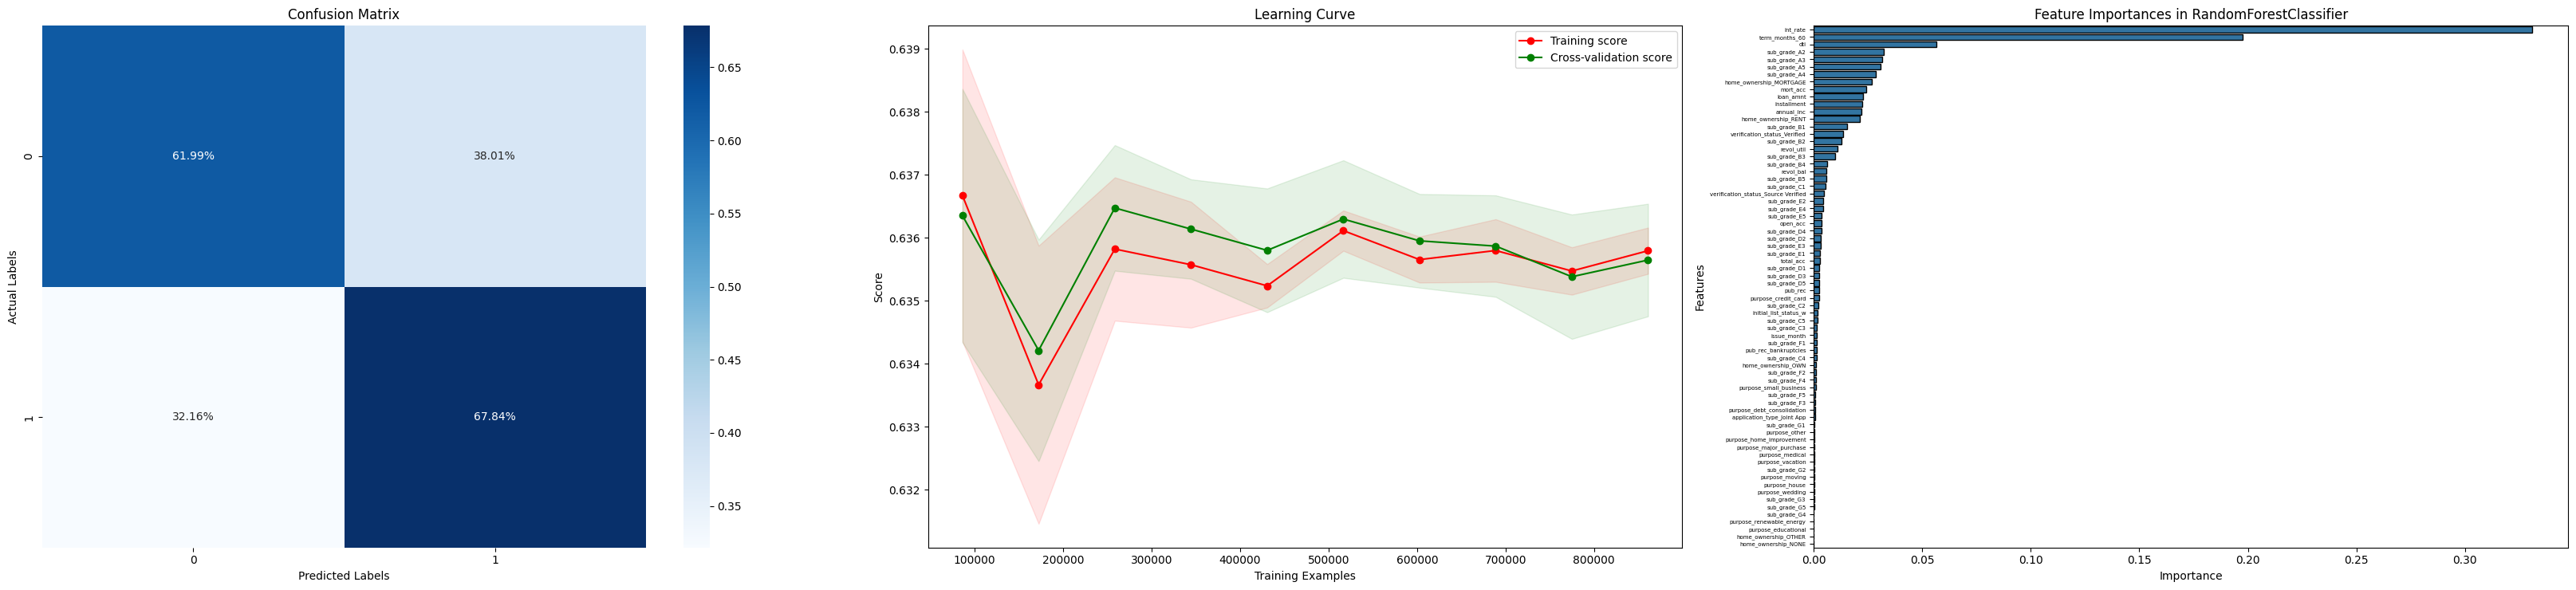

In [65]:
results.sort_values('mean_test_recall', inplace=True)
results.dropna(inplace=True)
print("Loading best parameters and defining")
# Initialize the model
best_n_estimators = results.iloc[-1]['param_n_estimators']
best_criterion = results.iloc[-1]['param_criterion']
best_max_features = results.iloc[-1]['param_max_features']
best_max_depth = results.iloc[-1]['param_max_depth']
best_min_samples_split = results.iloc[-1]['param_min_samples_split']
best_min_samples_leaf = results.iloc[-1]['param_min_samples_leaf']
best_bootstrap = results.iloc[-1]['param_bootstrap']

print(f"""Best Parameters:
 - N Estimators: {best_n_estimators}
 - Criterion: {best_criterion}
 - Max_Features {best_max_features}
 - Max Depth {best_max_depth}
 - """)
random_forest_classifier = RandomForestClassifier(class_weight='balanced',
                                    n_estimators=best_n_estimators, 
                                    criterion=best_criterion,
                                    max_features=best_max_features,
                                    max_depth=best_max_depth,
                                    min_samples_split=best_min_samples_split,
                                    min_samples_leaf=best_min_samples_leaf,
                                    bootstrap=best_bootstrap)

print("Fitting the model to the training data")
# Train the model
random_forest_classifier.fit(X_train, y_train)

print("Making predictions with the fit model")
# Make predictions
y_pred = random_forest_classifier.predict(X_test)

# print("Computing cross-validations")
# train_sizes, train_scores, test_scores = learning_curve(
#     random_forest_classifier, X, y, cv=5, n_jobs=-1, 
#     train_sizes=np.linspace(.1, 1.0, 10),
#     verbose=10)

print("Computing mean scores")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))

feature_importances = random_forest_classifier.feature_importances_

features = np.array(ML_columns)  # Assuming ML_columns are your feature names
importances = feature_importances

# Sorting features by importance
sorted_indices = np.argsort(importances)[::-1]
sorted_features = features[sorted_indices]
sorted_importances = importances[sorted_indices]

print("Making Plots")
fig, ax = plt.subplots(1, 3, figsize = [20*1.62, 7.5])

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizing the confusion matrix

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_ylabel('Actual Labels')
ax[0].set_xlabel('Predicted Labels')

ax[1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax[1].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
ax[1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax[1].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax[1].set_title('Learning Curve')
ax[1].set_xlabel('Training Examples')
ax[1].set_ylabel('Score')
ax[1].legend(loc="best")

sns.barplot(x=sorted_importances, y=sorted_features, edgecolor="black", ax=ax[2])
ax[2].set_title("Feature Importances in RandomForestClassifier")
ax[2].set_xlabel('Importance')
ax[2].set_ylabel('Features')
ax[2].tick_params(axis='y', labelsize=5)

fig.tight_layout()

### Neural Network

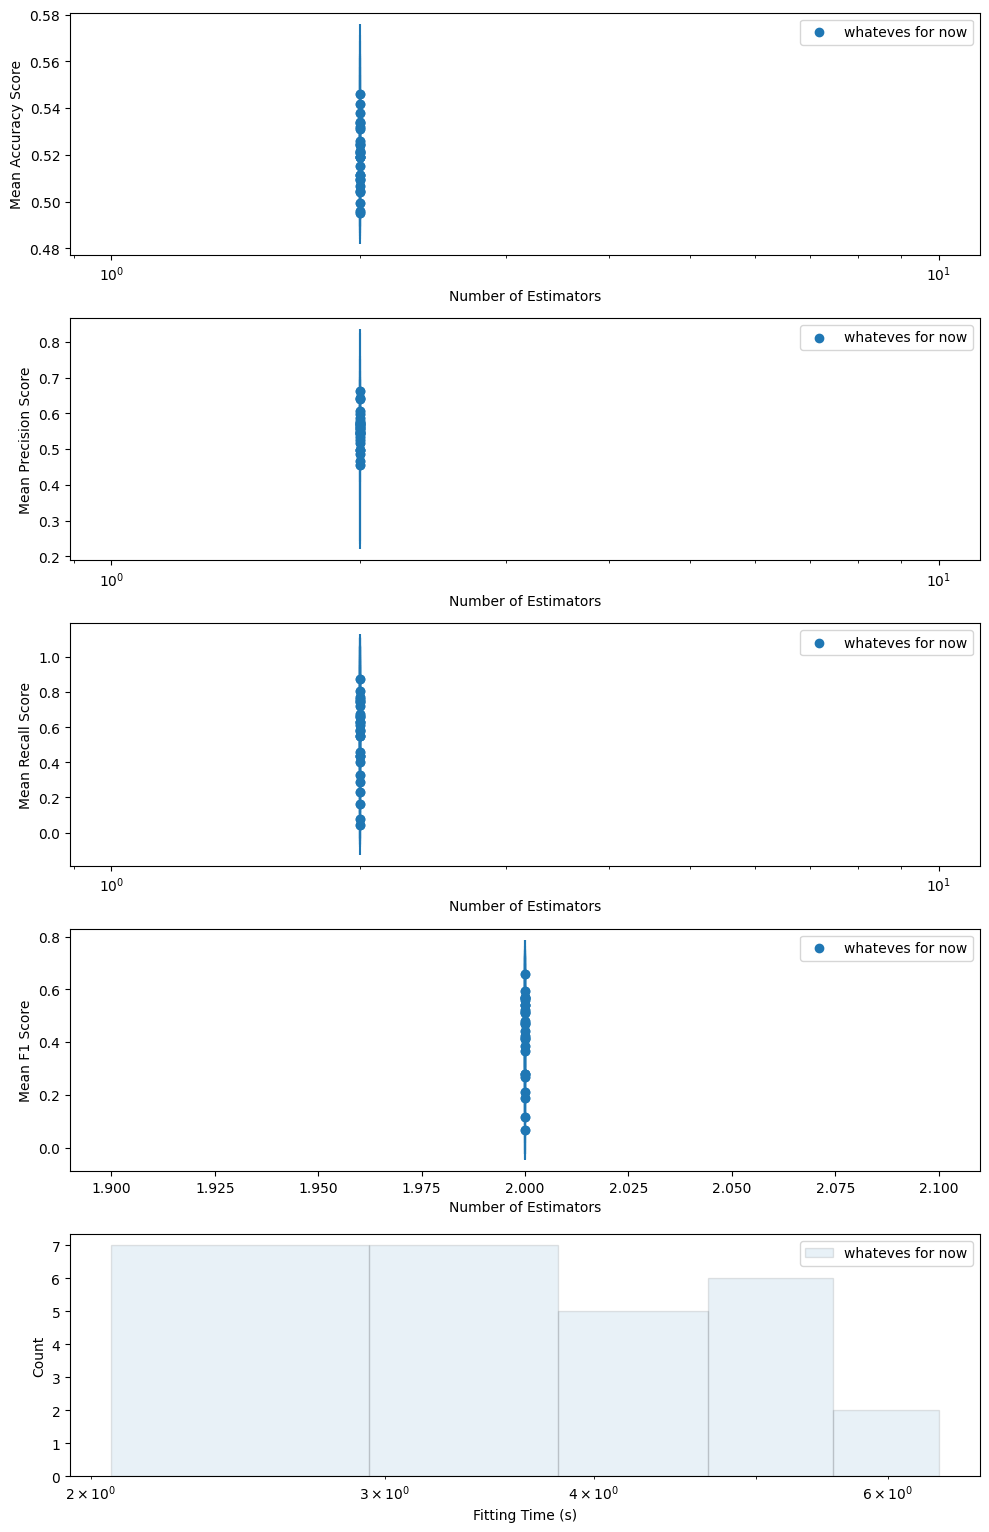

In [142]:
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight

mlp_classifier = MLPClassifier()

scoring = {
    'accuracy': 'accuracy',  # Default scorer
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}

param_grid = {
    'hidden_layer_sizes': [(50, 100), (50, 100, 50)],
    'activation': ['relu'],  # Common choices for activation functions
    'solver': ['adam'],  # Stochastic gradient descent and Adam optimizer
    'alpha': [0.0015, 0.002, 0.0025],  # L2 penalty (regularization term) parameter
    'learning_rate': ['constant'],  # Learning rate schedule
    'max_iter': [125, 150, 175],  # Maximum number of iterations. The solver iterates until convergence or this number of iterations.
}

prod = 5
for value in param_grid.values():
    prod *= len(value)
print(f"Total Number of Fits: {prod}")
grid_search = GridSearchCV(mlp_classifier,
                           param_grid,
                           cv=5,
                           verbose=False,
                           scoring=scoring,
                           refit='precision',
                           n_jobs=-1)

grid_search.fit(X_opt, y_opt)

clear_output(wait=True)

results = pd.DataFrame(grid_search.cv_results_)
results['ML_model'] = ["MLPClassifier"]*len(results)

for param in param_grid.keys():
    results[f'param_{param}'] = [row['params'][param] for _, row in results.iterrows()]

if cummulative_results is None:
    cummulative_results = results.copy()
else:
    cummulative_results = pd.concat([cummulative_results, results])

fig, ax = plt.subplots(5, figsize=[10, 25/1.62])

best_bw_time = bestbandwidth(results['mean_fit_time'])
min_time, max_time = results['mean_fit_time'].min(), results['mean_fit_time'].max()
nBins_time = int((max_time - min_time)/best_bw_time)
bins_time = np.linspace(min_time, max_time, num = nBins_time)

label = f'whateves for now'
n_estimators = [len(r) for r in results['param_hidden_layer_sizes']]
mean_scores = results['mean_test_accuracy']
std_scores = results['std_test_accuracy']
ax[0].errorbar(n_estimators, mean_scores, yerr=std_scores, fmt='o')
ax[0].scatter(n_estimators, mean_scores, label=label)

mean_scores = results['mean_test_precision']
std_scores = results['std_test_precision']
ax[1].errorbar(n_estimators, mean_scores, yerr=std_scores, fmt='o')
ax[1].scatter(n_estimators, mean_scores, label=label)

mean_scores = results['mean_test_recall']
std_scores = results['std_test_recall']
ax[2].errorbar(n_estimators, mean_scores, yerr=std_scores, fmt='o')
ax[2].scatter(n_estimators, mean_scores, label=label)

mean_scores = results['mean_test_f1_score']
std_scores = results['std_test_f1_score']
ax[3].errorbar(n_estimators, mean_scores, yerr=std_scores, fmt='o')
ax[3].scatter(n_estimators, mean_scores, label=label)

ax[4].hist(results['mean_fit_time'], alpha=0.1, edgecolor = 'k', bins=bins_time, label=label)

clear_output()

ax[0].set_xlabel('Number of Estimators')
ax[0].set_ylabel('Mean Accuracy Score')
ax[0].legend()

ax[1].set_xlabel('Number of Estimators')
ax[1].set_ylabel('Mean Precision Score')
ax[1].legend()

ax[2].set_xlabel('Number of Estimators')
ax[2].set_ylabel('Mean Recall Score')
ax[2].legend()

ax[3].set_xlabel('Number of Estimators')
ax[3].set_ylabel('Mean F1 Score')
ax[3].legend()

ax[4].set_xlabel("Fitting Time (s)")
ax[4].set_ylabel('Count')
ax[4].legend()

fig.tight_layout()

Loading best parameters and defining
Best Parameters:
 - Hidden Layers: (50, 100)
 - Activation: relu
 - Solver adam
 - Alpha 0.002
 - Learning Rate constant
 - Max Iterations 150
Fitting the model to the training data
Making predictions with the fit model
Computing mean scores
Accuracy: 0.49810098302055406
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     53916
           1       0.50      1.00      0.66     53508

    accuracy                           0.50    107424
   macro avg       0.25      0.50      0.33    107424
weighted avg       0.25      0.50      0.33    107424

Making Plots


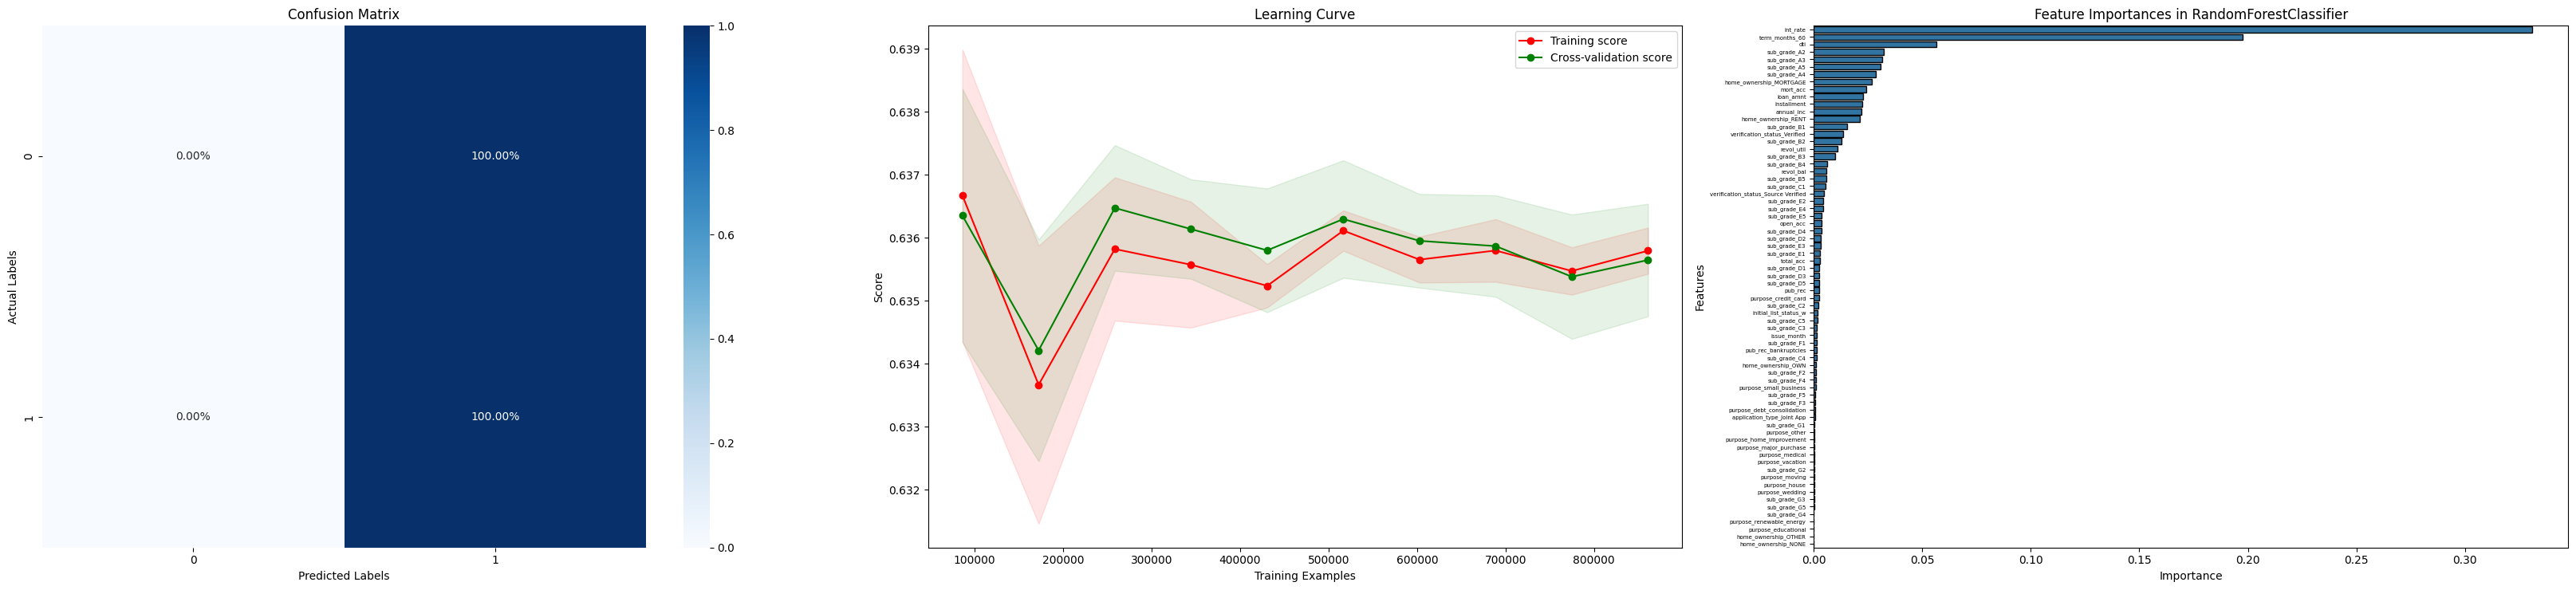

In [143]:
results.sort_values('mean_test_precision', inplace=True)
results.dropna(inplace=True)
print("Loading best parameters and defining")
# Initialize the model
best_hidden_layer_sizes = results.iloc[-1]['param_hidden_layer_sizes']
best_activation = results.iloc[-1]['param_activation']
best_solver = results.iloc[-1]['param_solver']
best_alpha = results.iloc[-1]['param_alpha']
best_learning_rate = results.iloc[-1]['param_learning_rate']
best_max_iter = results.iloc[-1]['param_max_iter']

print(f"""Best Parameters:
 - Hidden Layers: {best_hidden_layer_sizes}
 - Activation: {best_activation}
 - Solver {best_solver}
 - Alpha {best_alpha}
 - Learning Rate {best_learning_rate}
 - Max Iterations {best_max_iter}""")

mlp_classifier = MLPClassifier(hidden_layer_sizes=best_hidden_layer_sizes, 
                               activation=best_activation,
                               solver=best_solver,
                               alpha=best_alpha,
                               learning_rate=best_learning_rate,
                               max_iter=best_max_iter)

print("Fitting the model to the training data")

# Train the model
mlp_classifier.fit(X_train, y_train)

print("Making predictions with the fit model")
# Make predictions
y_pred = mlp_classifier.predict(X_test)

# print("Computing cross-validations")
# train_sizes, train_scores, test_scores = learning_curve(
#     mlp_classifier, X, y, cv=5, n_jobs=-1, 
#     train_sizes=np.linspace(.1, 1.0, 10),
#     verbose=10)

print("Computing mean scores")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))

feature_importances = random_forest_classifier.feature_importances_

features = np.array(ML_columns)  # Assuming ML_columns are your feature names
importances = feature_importances

# Sorting features by importance
sorted_indices = np.argsort(importances)[::-1]
sorted_features = features[sorted_indices]
sorted_importances = importances[sorted_indices]

print("Making Plots")
fig, ax = plt.subplots(1, 3, figsize = [20*1.62, 7.5])

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizing the confusion matrix

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_ylabel('Actual Labels')
ax[0].set_xlabel('Predicted Labels')

ax[1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax[1].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
ax[1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax[1].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax[1].set_title('Learning Curve')
ax[1].set_xlabel('Training Examples')
ax[1].set_ylabel('Score')
ax[1].legend(loc="best")

sns.barplot(x=sorted_importances, y=sorted_features, edgecolor="black", ax=ax[2])
ax[2].set_title("Feature Importances in RandomForestClassifier")
ax[2].set_xlabel('Importance')
ax[2].set_ylabel('Features')
ax[2].tick_params(axis='y', labelsize=5)

fig.tight_layout()

In [138]:
cummulative_results[cummulative_results['ML_model'] == 'RandomForestClassifier'].sort_values('mean_test_recall').iloc[-1]['params']



{'bootstrap': False,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 100}

In [198]:
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real

df = pd.read_csv('../outputs/prototype/models/Cummulative_Results_GridSearchCV.csv', index_col=0)
df.sort_values(['mean_test_f1_score'])

model = df.sort_values(['mean_test_f1_score']).iloc[-1]['ML_model']
params = eval(df.sort_values(['mean_test_f1_score']).iloc[-1]['params'])
if model == 'RandomForestClassifier':
    clf = RandomForestClassifier(bootstrap=params['bootstrap'],
                                 class_weight=params['class_weight'],
                                 criterion=params['criterion'],
                                 max_features=params['max_features'])
    search_spaces = {
    'max_depth': Integer(int(params['max_depth']/2), int(params['max_depth']*1.5)),
    'min_samples_leaf': Integer(int(params['min_samples_leaf']/2), int(params['min_samples_leaf']*1.5)),
    'min_samples_split': Integer(int(params['min_samples_split']/2), int(params['min_samples_split']*1.5)),
    'n_estimators': Integer(int(params['n_estimators']/2), int(params['n_estimators']*1.5))
    }

elif model == 'LogisticRegression':
    print("Model: LogisticRegression")
    print(f"Starting Parameters: {params}")
    clf = LogisticRegression(penalty=params['penalty'],
                             solver=params['solver'])
    
    search_spaces = {
    'C': Real(params['C']/2, params['C']*1.5)
    }
    
print(f"Model: {model}")
print(f"Starting Parameters: {params}")

bayes_search = BayesSearchCV(
    estimator=clf,
    search_spaces=search_spaces,
    scoring=make_scorer(recall_score),
    n_iter=50,
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=10
)

np.int = int
bayes_search.fit(X_opt, y_opt)

best_params = bayes_search.best_params_
print("Best parameters to maximize recall: ", best_params)

Model: RandomForestClassifier
Starting Parameters: {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 20, 'n_estimators': 359}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Loading best parameters and defining
Fitting the model to the training data
[CV 5/5; 1/1] START max_depth=9, min_samples_leaf=5, min_samples_split=29, n_estimators=292
[CV 5/5; 1/1] END max_depth=9, min_samples_leaf=5, min_samples_split=29, n_estimators=292;, score=0.619 total time=   3.5s
[CV 2/5; 1/1] START max_depth=13, min_samples_leaf=6, min_samples_split=16, n_estimators=520
[CV 2/5; 1/1] END max_depth=13, min_samples_leaf=6, min_samples_split=16, n_estimators=520;, score=0.597 total time=   8.6s
[CV 5/5; 1/1] START max_depth=13, min_samples_leaf=3, min_samples_split=22, n_estimators=467
[CV 5/5; 1/1] END max_depth=13, min_samples_leaf=3, min_samples_split=22, n_estimators=467;, score=0.540 total time=   8.3s
[CV 2/5; 1/1] START max_depth=13, min_samples_leaf=4, min_samples_split=21, n_estimators=436
[CV 2/5; 1/1] END max_depth=13, min_samples_leaf=4, min_samples_split=21, n_estimators=436;, score=0.595 total time=  11.8s
[CV 3/5; 1/1] START max_depth=12, min_samples_leaf=6, min_

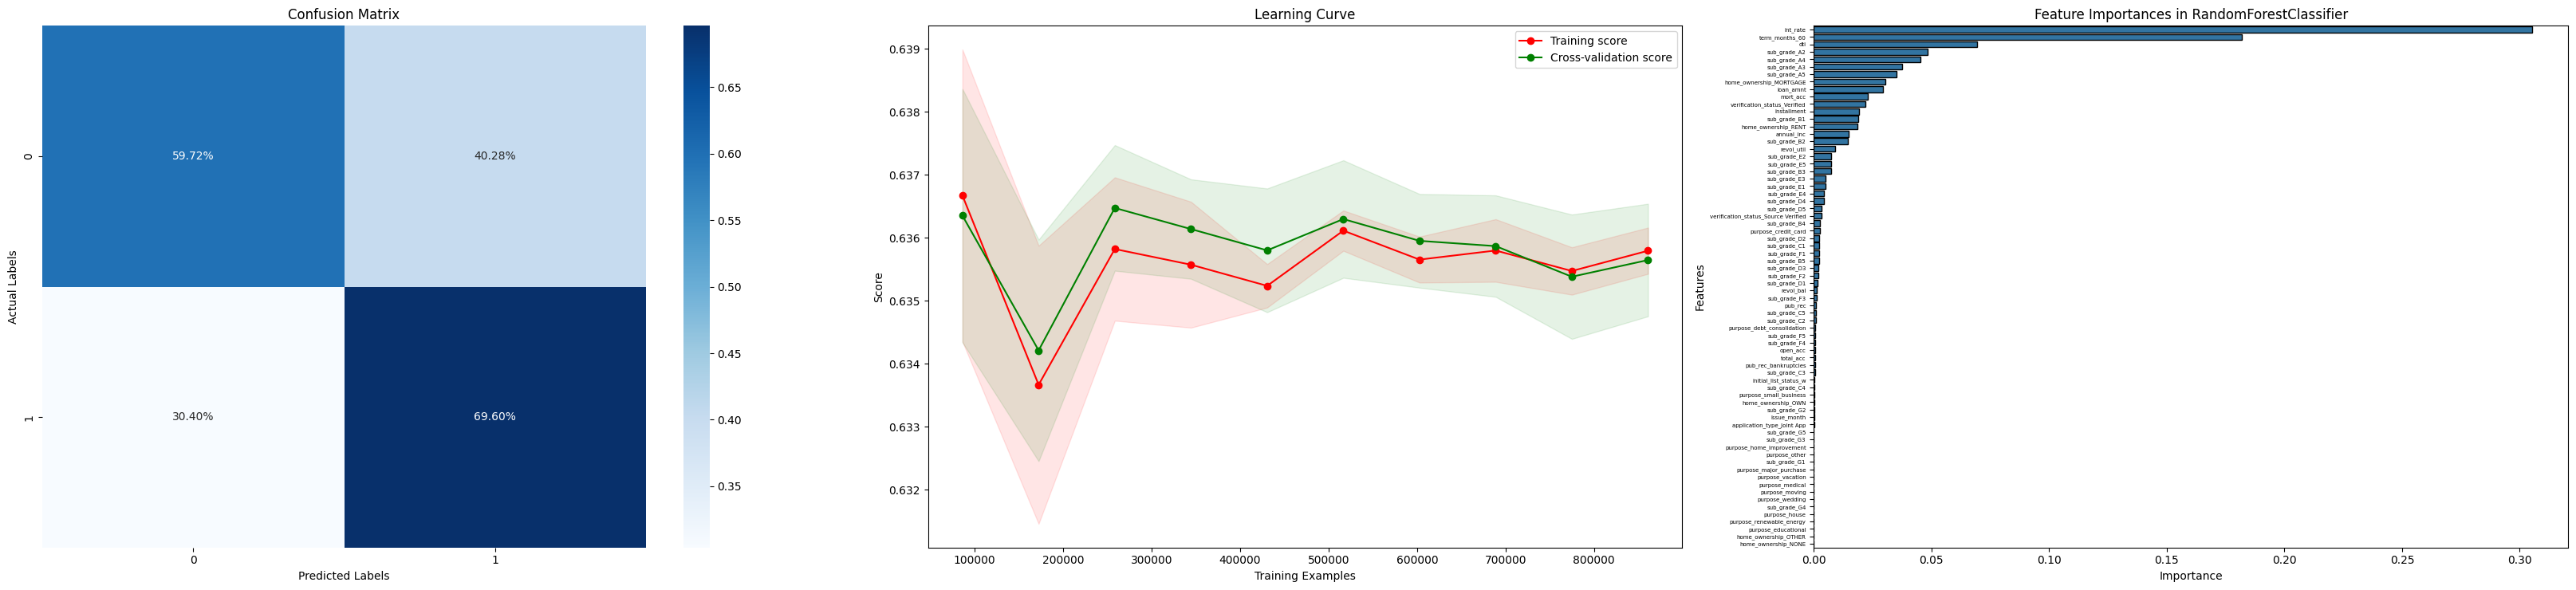

In [199]:
results.sort_values('mean_test_recall', inplace=True)
results.dropna(inplace=True)
print("Loading best parameters and defining")

if model == 'RandomForestClassifier':
    clf = RandomForestClassifier(bootstrap=params['bootstrap'],
                             class_weight=params['class_weight'],
                             criterion=params['criterion'],
                             max_features=params['max_features'],
                             max_depth=best_params['max_depth'],
                             min_samples_leaf=best_params['min_samples_leaf'],
                             min_samples_split=best_params['min_samples_split'],
                             n_estimators=best_params['n_estimators'],
                             )
elif model == 'LogisticRegression':
    clf = LogisticRegression(penalty=params['penalty'],
                             solver=params['solver'],
                             C=best_params['C'])

print("Fitting the model to the training data")
# Train the model
clf.fit(X_train, y_train)

print("Making predictions with the fit model")
# Make predictions
y_pred = clf.predict(X_test)

# print("Computing cross-validations")
# train_sizes, train_scores, test_scores = learning_curve(
#     random_forest_classifier, X, y, cv=5, n_jobs=-1, 
#     train_sizes=np.linspace(.1, 1.0, 10),
#     verbose=10)

print("Computing mean scores")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))

feature_importances = clf.feature_importances_

features = np.array(ML_columns)  # Assuming ML_columns are your feature names
importances = feature_importances

# Sorting features by importance
sorted_indices = np.argsort(importances)[::-1]
sorted_features = features[sorted_indices]
sorted_importances = importances[sorted_indices]

print("Making Plots")
fig, ax = plt.subplots(1, 3, figsize = [20*1.62, 7.5])

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizing the confusion matrix

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_ylabel('Actual Labels')
ax[0].set_xlabel('Predicted Labels')

ax[1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax[1].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
ax[1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax[1].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax[1].set_title('Learning Curve')
ax[1].set_xlabel('Training Examples')
ax[1].set_ylabel('Score')
ax[1].legend(loc="best")

sns.barplot(x=sorted_importances, y=sorted_features, edgecolor="black", ax=ax[2])
ax[2].set_title("Feature Importances in RandomForestClassifier")
ax[2].set_xlabel('Importance')
ax[2].set_ylabel('Features')
ax[2].tick_params(axis='y', labelsize=5)

fig.tight_layout()

In [394]:
probabilities = clf.predict_proba(loans_data.drop(['loan_status', 'Probability Default', 'Profit_or_Loss', 'Expected_Value'], axis='columns'))
loans_data['Probability Default'] = [prob[1] for prob in probabilities]

<BarContainer object of 36 artists>

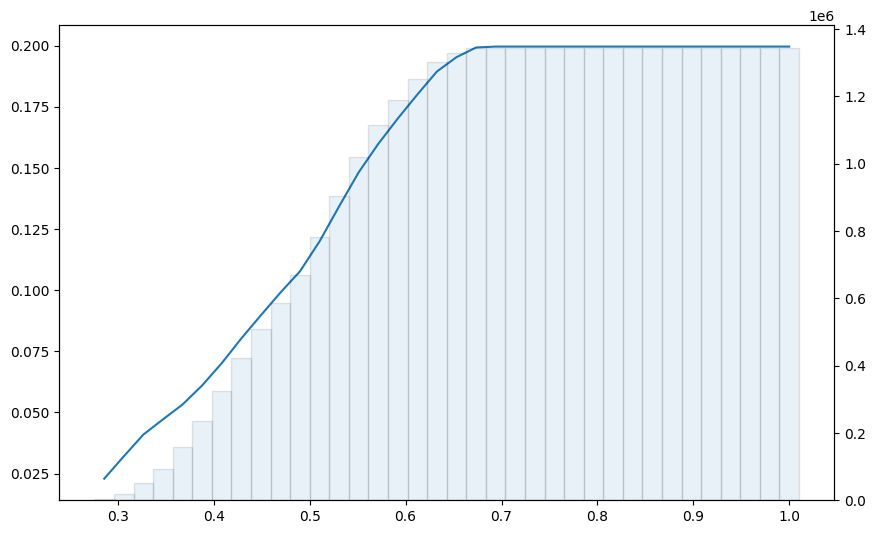

In [311]:
threshs = np.linspace(0, 1, 50)
acc = np.array([0. for _ in range(len(threshs))])
N = np.array([0 for _ in range(len(threshs))])
for i, thresh in enumerate(threshs):
    thresh_mask = (loans_data['Probability Default'] <= thresh)
    loans_data_thresh = loans_data[thresh_mask]
    if len(loans_data_thresh) == 0:
        acc[i] = np.nan
    else:
        acc[i] = len(loans_data_thresh[loans_data_thresh['loan_status'] == 1])/len(loans_data_thresh)
    N[i] = len(loans_data_thresh)

fig, ax = plt.subplots(figsize = [10, 10/1.62])
ax.plot(threshs, acc)
ax2 = ax.twinx()
ax2.bar(threshs, N, width=np.diff(threshs)[0], color=None, edgecolor='k', alpha=0.1)

In [303]:
# Defining the connection to the database
conn = sqlite3.connect(sqlite_file)

# Loading data into dataframe
data_fetch_query = f"""SELECT id, total_pymnt
                       FROM loans_data"""

loans_data_paymnts = pd.read_sql_query(data_fetch_query, conn)

# Closing connection
conn.close()

loans_data_paymnts = loans_data_paymnts[loans_data_paymnts['id'].apply(lambda x: x in loans_data.index)]

combined_data = pd.merge(loans_data, loans_data_paymnts, on='id', how='inner')
combined_data['Profit_or_Loss'] = combined_data['total_pymnt'] - combined_data['loan_amnt']

Maximum profit of 677771233.732903 is achieved at a threshold of 0.60


Text(0, 0.5, 'Number of Loans With Probability Default Below Threshold')

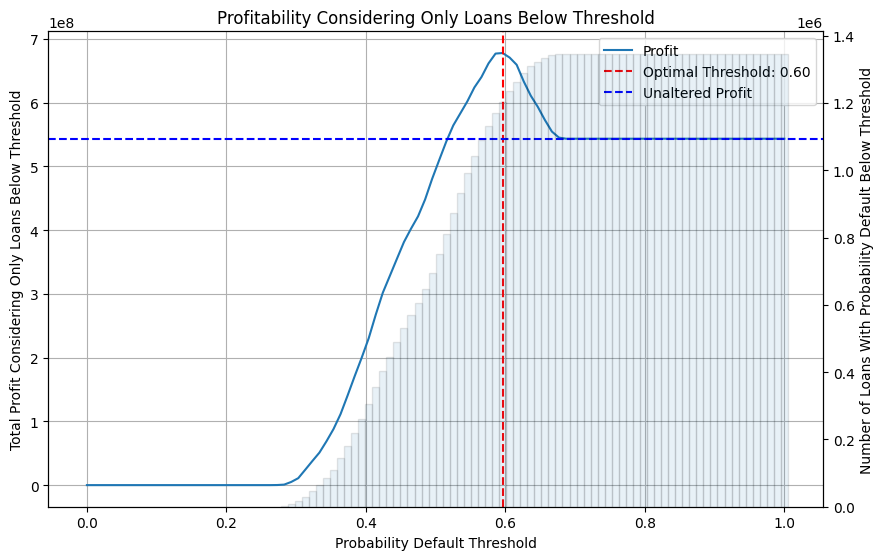

In [313]:
def calculate_profit(df, threshold):
    # Predicted defaults based on threshold
    return df[df['Probability Default'] <= threshold]['Profit_or_Loss'].sum()

actual_profit = combined_data['Profit_or_Loss'].sum()
# Evaluate profits at various thresholds
thresholds = np.linspace(0, 1, 100)
profits = np.array([calculate_profit(combined_data, thresh) for thresh in thresholds])
Ns = np.array([len(combined_data[combined_data['Probability Default'] <= thresh]) for thresh in thresholds])

# Find the optimal threshold
max_profit = profits.max()
optimal_threshold = thresholds[profits.argmax()]
print(f"Maximum profit of {max_profit} is achieved at a threshold of {optimal_threshold:.2f}")

# Plot the profit curve using fig, ax
fig, ax = plt.subplots(figsize=(10, 10/1.62))
ax.plot(thresholds, profits, label='Profit')
ax.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
ax.axhline(actual_profit, color='blue', linestyle='--', label='Unaltered Profit')
ax.set_xlabel('Probability Default Threshold')
ax.set_ylabel('Total Profit Considering Only Loans Below Threshold')
ax.set_title('Profitability Considering Only Loans Below Threshold')
ax.legend()
ax.grid(True)

ax2 = ax.twinx()
ax2.bar(thresholds, Ns, width=np.diff(thresholds)[0], color=None, edgecolor='k', alpha=0.1)
ax2.set_ylabel('Number of Loans With Probability Default Below Threshold')


Text(0, 0.5, 'Number of Loans With Probability Default Below Threshold')

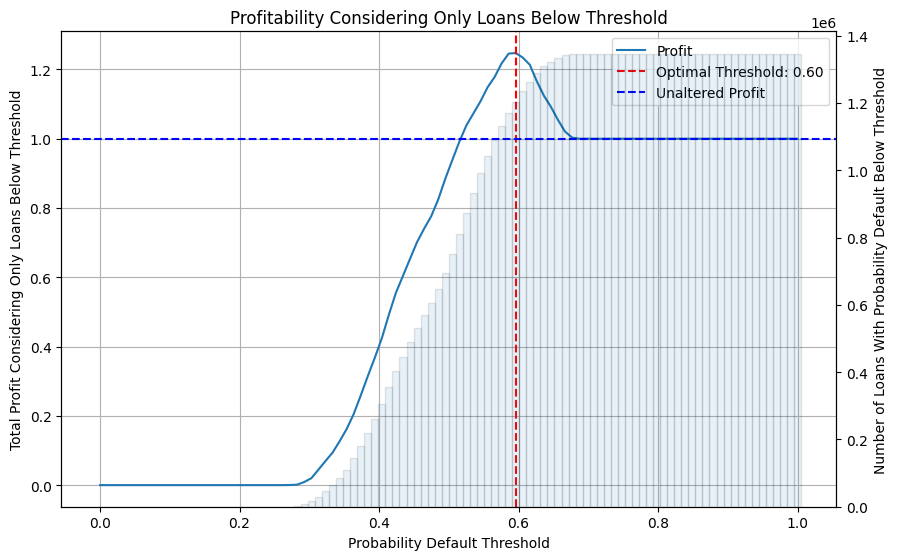

In [314]:
# Plot the profit curve using fig, ax
fig, ax = plt.subplots(figsize=(10, 10/1.62))

relative_profits = profits/actual_profit

max_relative_profit = relative_profits.max()
optimal_threshold = thresholds[profits.argmax()]

ax.plot(thresholds, relative_profits, label='Profit')
ax.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
ax.axhline(1, color='blue', linestyle='--', label='Unaltered Profit')
ax.set_xlabel('Probability Default Threshold')
ax.set_ylabel('Total Profit Considering Only Loans Below Threshold')
ax.set_title('Profitability Considering Only Loans Below Threshold')
ax.legend()
ax.grid(True)

ax2 = ax.twinx()
ax2.bar(thresholds, Ns, width=np.diff(thresholds)[0], color=None, edgecolor='k', alpha=0.1)
ax2.set_ylabel('Number of Loans With Probability Default Below Threshold')


array([[1.20000000e+04, 1.44899998e+01, 4.13000000e+02, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [2.00000000e+04, 1.58000002e+01, 4.84239990e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.40000000e+03, 1.13900003e+01, 2.76559998e+02, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [6.40000000e+03, 9.48999977e+00, 2.04990005e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.58750000e+04, 1.40900002e+01, 5.43270020e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.00000000e+03, 1.07799997e+01, 1.63179993e+02, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

Maximum profit of 133808223.87169312 is achieved at a threshold of 0.60


Text(0, 0.5, 'Number of Loans With Probability Default Below Threshold')

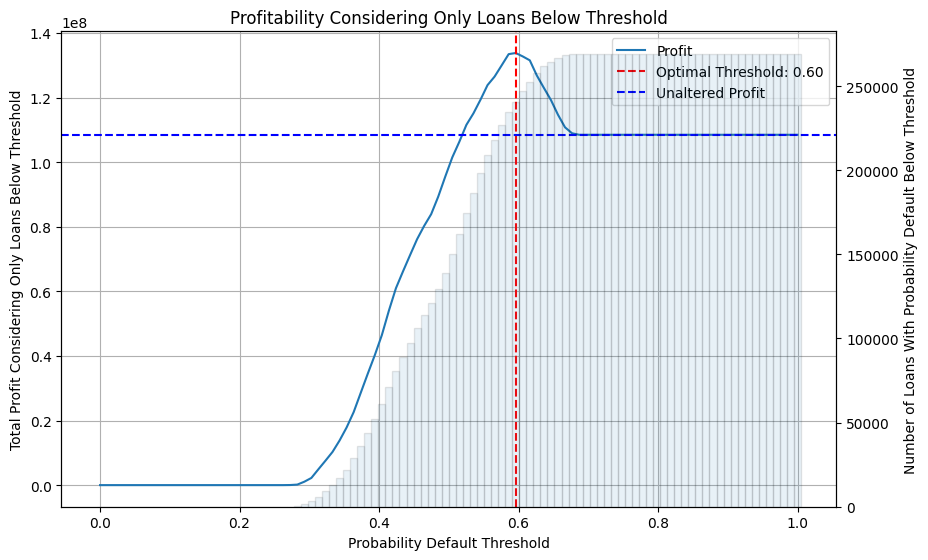

In [334]:
X_train, X_test, y_train, y_test = train_test_split(
    combined_data.drop(['loan_status'], axis=1),
    combined_data['loan_status'], test_size=0.2, random_state=42)

df_test = X_test.join(y_test)

def calculate_profit(df, threshold):
    # Predicted defaults based on threshold
    return df[df['Probability Default'] <= threshold]['Profit_or_Loss'].sum()

actual_profit = df_test['Profit_or_Loss'].sum()
# Evaluate profits at various thresholds
thresholds = np.linspace(0, 1, 100)
profits = np.array([calculate_profit(df_test, thresh) for thresh in thresholds])
Ns = np.array([len(df_test[df_test['Probability Default'] <= thresh]) for thresh in thresholds])

# Find the optimal threshold
max_profit = profits.max()
optimal_threshold = thresholds[profits.argmax()]
print(f"Maximum profit of {max_profit} is achieved at a threshold of {optimal_threshold:.2f}")

# Plot the profit curve using fig, ax
fig, ax = plt.subplots(figsize=(10, 10/1.62))
ax.plot(thresholds, profits, label='Profit')
ax.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
ax.axhline(actual_profit, color='blue', linestyle='--', label='Unaltered Profit')
ax.set_xlabel('Probability Default Threshold')
ax.set_ylabel('Total Profit Considering Only Loans Below Threshold')
ax.set_title('Profitability Considering Only Loans Below Threshold')
ax.legend()
ax.grid(True)

ax2 = ax.twinx()
ax2.bar(thresholds, Ns, width=np.diff(thresholds)[0], color=None, edgecolor='k', alpha=0.1)
ax2.set_ylabel('Number of Loans With Probability Default Below Threshold')


Making Plots


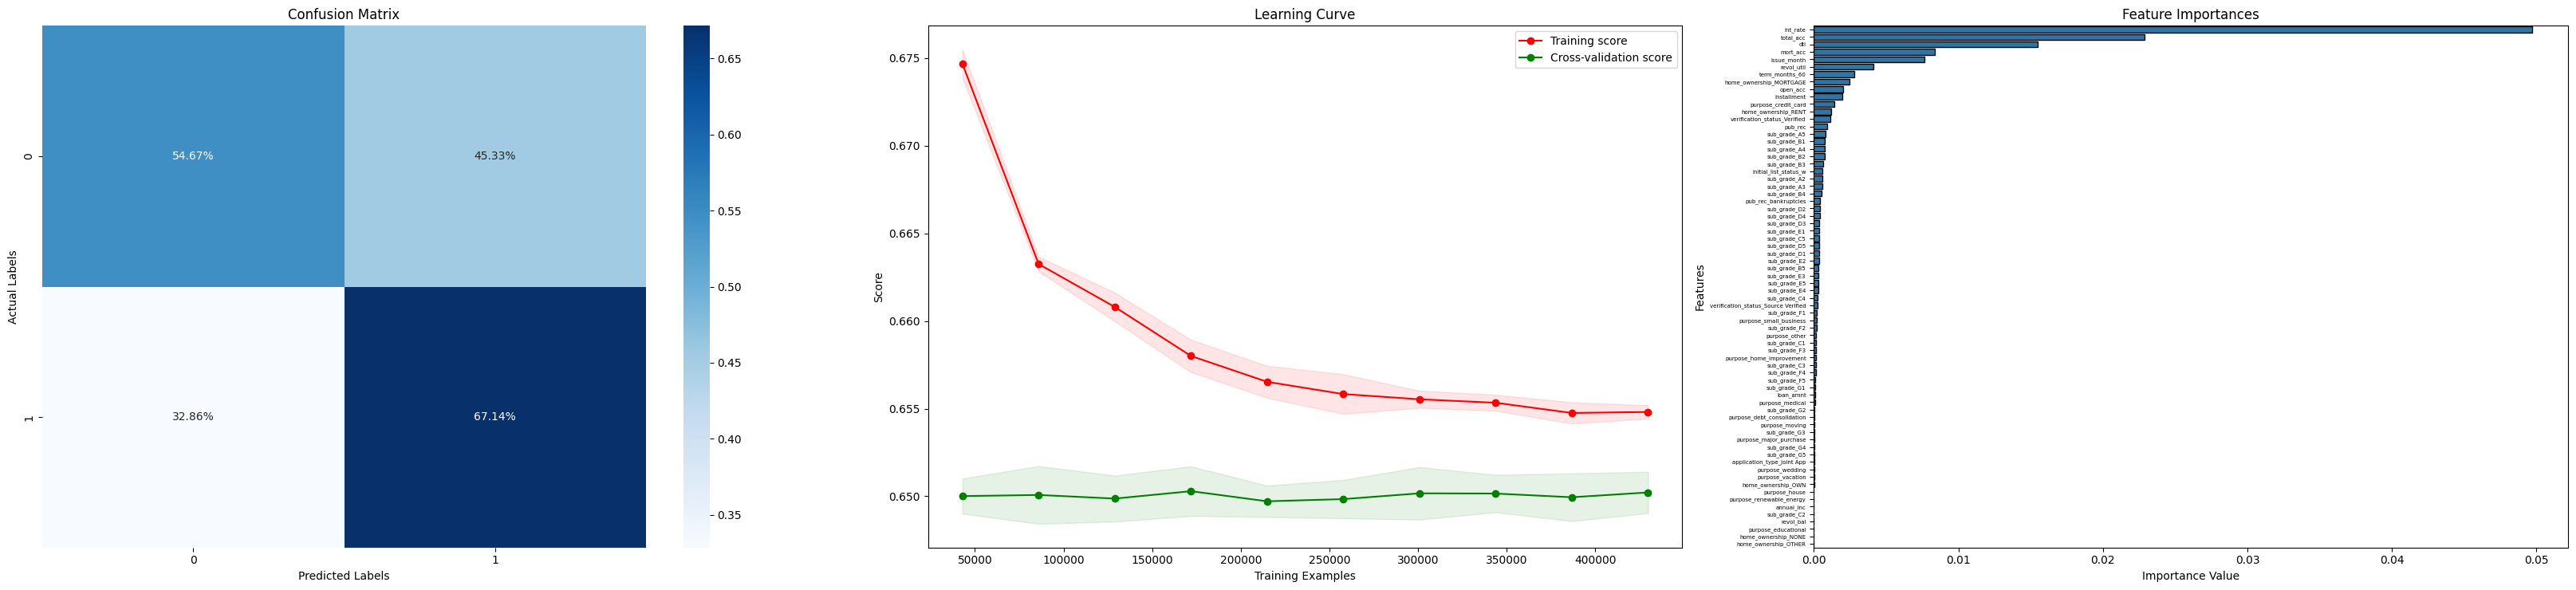

In [436]:
from sklearn.svm import SVC as SupportVectorClassifier

df = pd.read_csv('../outputs/prototype/stats/Cummulative_Results_BayesSearchCV.csv', index_col=0)

model = df.sort_values('mean_test_score').iloc[-1]['ML_model']
params = string_to_dict(df.sort_values('mean_test_score').iloc[-1]['params'])


print("Loading best parameters and defining")

if model == 'RandomForestClassifier':
    clf = RandomForestClassifier(**params)
elif model == 'LogisticRegression':
    clf = LogisticRegression(**params)
elif model == 'SupportVectorClassifier':
    clf = SupportVectorClassifier(**params)

print("Fitting the model to the training data")
# Train the model
clf.fit(X_train, y_train)

print("Making predictions with the fit model")
# Make predictions
y_pred = clf.predict(X_test)

# print("Computing cross-validations")
# train_sizes, train_scores, test_scores = learning_curve(
#     random_forest_classifier, X, y, cv=5, n_jobs=-1, 
#     train_sizes=np.linspace(.1, 1.0, 10),
#     verbose=False)

# print("Computing mean scores")
# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)

# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))

if model == 'RandomForestClassifier':
    feature_importances = clf.feature_importances_

    features = np.array(ML_columns)  # Assuming ML_columns are your feature names
    importances = feature_importances

    # Sorting features by importance
    sorted_indices = np.argsort(importances)[::-1]
    sorted_features = features[sorted_indices]
    sorted_importances = importances[sorted_indices]
elif model == 'LogisticRegression':
    # Logistic Regression coefficients
    coefficients = clf.coef_[0]  # Assuming clf is your Logistic Regression model

    features = np.array(ML_columns)  # Assuming ML_columns are your feature names
    importances = np.abs(coefficients)

    # Sorting features by the absolute value of coefficients
    sorted_indices = np.argsort(np.abs(importances))[::-1]
    sorted_features = features[sorted_indices]
    sorted_importances = importances[sorted_indices]
elif model == 'SupportVectorClassifier':
    if clf.kernel == 'linear':
        # SVC coefficients for linear kernel
        coefficients = clf.coef_[0]  # Assuming clf is your SVC model

        features = np.array(ML_columns)  # Assuming ML_columns are your feature names
        importances = np.abs(coefficients)

        # Sorting features by the absolute value of coefficients
        sorted_indices = np.argsort(importances)[::-1]
        sorted_features = features[sorted_indices]
        sorted_importances = importances[sorted_indices]
    else:
        # For non-linear kernels, feature importances are not directly available
        sorted_features = None
        sorted_importances = None
        print("Feature importances are not available for non-linear kernels in SVC")
clear_output(wait=True)

print("Making Plots")
fig, ax = plt.subplots(1, 3, figsize = [20*1.62, 7.5])

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalizing the confusion matrix

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_ylabel('Actual Labels')
ax[0].set_xlabel('Predicted Labels')

ax[1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax[1].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
ax[1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax[1].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax[1].set_title('Learning Curve')
ax[1].set_xlabel('Training Examples')
ax[1].set_ylabel('Score')
ax[1].legend(loc="best")

sns.barplot(x=sorted_importances, y=sorted_features, edgecolor="black", ax=ax[2])
ax[2].set_title("Feature Importances")
ax[2].set_xlabel('Importance Value')
ax[2].set_ylabel('Features')
ax[2].tick_params(axis='y', labelsize=5)

fig.tight_layout()

In [440]:
params

{'C': 1.5028080650031657e-05, 'penalty': 'l2', 'solver': 'lbfgs'}

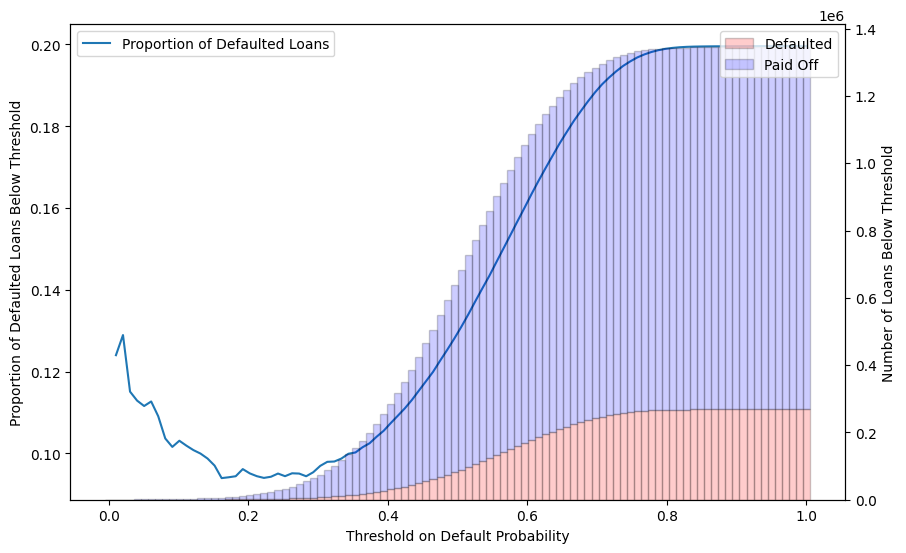

In [388]:
probabilities = clf.predict_proba(loans_data.drop(['loan_status', 'Default Probability', 'Profit_or_Loss', 'Expected_Value'], axis='columns'))
loans_data['Default Probability'] = [prob[1] for prob in probabilities]

threshs = np.linspace(0, 1, 100)
prop = np.array([0. for _ in range(len(threshs))])
N = np.array([0 for _ in range(len(threshs))])
N_defaulted = np.array([0 for _ in range(len(threshs))])
N_paid = np.array([0 for _ in range(len(threshs))])
for i, thresh in enumerate(threshs):
    thresh_mask = (loans_data['Default Probability'] <= thresh)
    loans_data_thresh = loans_data[thresh_mask]
    if len(loans_data_thresh) == 0:
        prop[i] = np.nan
    else:
        prop[i] = len(loans_data_thresh[loans_data_thresh['loan_status'] == 1])/len(loans_data_thresh)
    N[i] = len(loans_data_thresh)
    N_defaulted[i] = len(loans_data_thresh[loans_data_thresh['loan_status'] == 1])
    N_paid[i] = len(loans_data_thresh[loans_data_thresh['loan_status'] == 0])

fig, ax = plt.subplots(figsize = [10, 10/1.62])
ax.plot(threshs, prop, label='Proportion of Defaulted Loans')
ax.set_xlabel('Threshold on Default Probability')
ax.set_ylabel('Proportion of Defaulted Loans Below Threshold')
ax.legend(loc='upper left')

ax2 = ax.twinx()
# ax2.bar(threshs, N, width=np.diff(threshs)[0], color=None, edgecolor='k', alpha=0.1)
ax2.bar(threshs, N_defaulted, width=np.diff(threshs)[0], color='Red', edgecolor='k', alpha=0.2, label='Defaulted')
ax2.bar(threshs, N_paid, width=np.diff(threshs)[0], color='Blue', edgecolor='k', alpha=0.2, label='Paid Off', bottom=N_defaulted)
ax2.set_ylabel("Number of Loans Below Threshold")
ax2.legend(loc='upper right')

Maximum profit of 684322760.6420978 is achieved at a threshold of 0.64


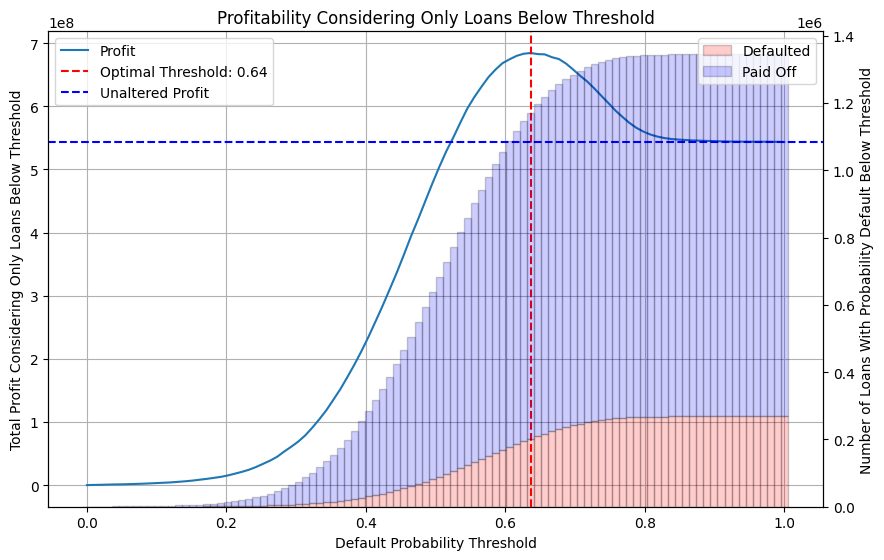

In [380]:
# Defining the connection to the database
conn = sqlite3.connect(sqlite_file)

# Loading data into dataframe
data_fetch_query = f"""SELECT id, total_pymnt
                       FROM loans_data"""

loans_data_paymnts = pd.read_sql_query(data_fetch_query, conn)

# Closing connection
conn.close()

loans_data_paymnts = loans_data_paymnts[loans_data_paymnts['id'].apply(lambda x: x in loans_data.index)]

combined_data = pd.merge(loans_data, loans_data_paymnts, on='id', how='inner')
combined_data['Profit_or_Loss'] = combined_data['total_pymnt'] - combined_data['loan_amnt']

def calculate_profit(df, threshold):
    # Predicted defaults based on threshold
    return df[df['Default Probability'] <= threshold]['Profit_or_Loss'].sum()

actual_profit = combined_data['Profit_or_Loss'].sum()
# Evaluate profits at various thresholds
thresholds = np.linspace(0, 1, 100)
profits = np.array([calculate_profit(combined_data, thresh) for thresh in thresholds])
Ns = np.array([len(combined_data[combined_data['Default Probability'] <= thresh]) for thresh in thresholds])
Ns_defaulted = np.array([len(combined_data[(combined_data['Default Probability'] <= thresh) & (combined_data['loan_status'] == 1)]) for thresh in thresholds])
Ns_paid = np.array([len(combined_data[(combined_data['Default Probability'] <= thresh) & (combined_data['loan_status'] == 0)]) for thresh in thresholds])

# Find the optimal threshold
max_profit = profits.max()
optimal_threshold = thresholds[profits.argmax()]
print(f"Maximum profit of {max_profit} is achieved at a threshold of {optimal_threshold:.2f}")

# Plot the profit curve using fig, ax
fig, ax = plt.subplots(figsize=(10, 10/1.62))
ax.plot(thresholds, profits, label='Profit')
ax.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
ax.axhline(actual_profit, color='blue', linestyle='--', label='Unaltered Profit')
ax.set_xlabel('Default Probability Threshold')
ax.set_ylabel('Total Profit Considering Only Loans Below Threshold')
ax.set_title('Profitability Considering Only Loans Below Threshold')
ax.legend(loc='upper left')
ax.grid(True)

ax2 = ax.twinx()
# ax2.bar(thresholds, Ns, width=np.diff(thresholds)[0], color=None, edgecolor='k', alpha=0.1)
ax2.bar(thresholds, Ns_defaulted, width=np.diff(thresholds)[0], color='Red', edgecolor='k', alpha=0.2, label='Defaulted')
ax2.bar(thresholds, Ns_paid, width=np.diff(thresholds)[0], color='Blue', edgecolor='k', alpha=0.2, label='Paid Off', bottom=Ns_defaulted)
ax2.set_ylabel('Number of Loans With Default Probability Below Threshold')
ax2.legend(loc='upper right')

Maximum Relative Profit of 1.2594282561556953 is achieved at a threshold of 0.64


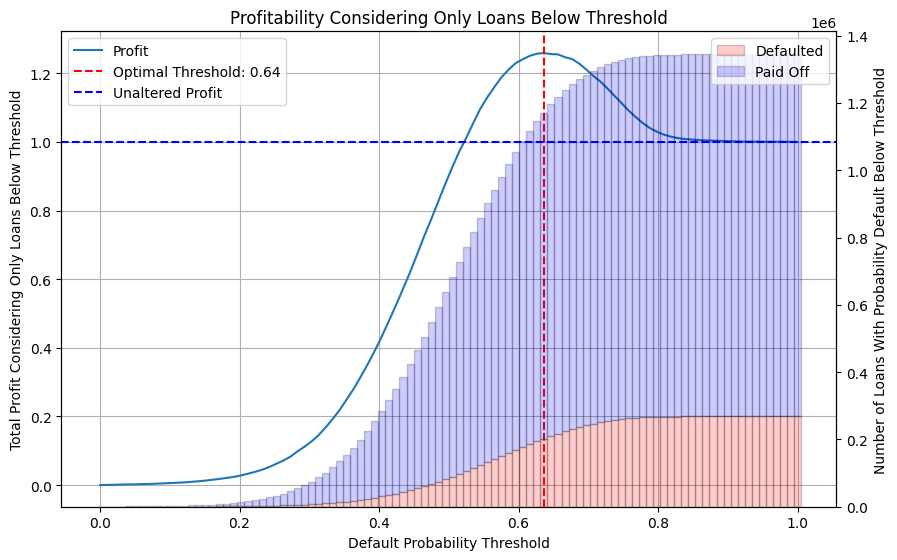

In [387]:
relative_profit = profits/actual_profit

# Find the optimal threshold
max_relative_profit = relative_profit.max()
optimal_threshold = thresholds[relative_profit.argmax()]
print(f"Maximum Relative Profit of {max_relative_profit} is achieved at a threshold of {optimal_threshold:.2f}")

# Plot the profit curve using fig, ax
fig, ax = plt.subplots(figsize=(10, 10/1.62))
ax.plot(thresholds, relative_profit, label='Profit')
ax.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
ax.axhline(1, color='blue', linestyle='--', label='Unaltered Profit')
ax.set_xlabel('Default Probability Threshold')
ax.set_ylabel('Total Profit Considering Only Loans Below Threshold')
ax.set_title('Profitability Considering Only Loans Below Threshold')
ax.legend(loc='upper left')
ax.grid(True)

ax2 = ax.twinx()
# ax2.bar(thresholds, Ns, width=np.diff(thresholds)[0], color=None, edgecolor='k', alpha=0.1)
ax2.bar(thresholds, Ns_defaulted, width=np.diff(thresholds)[0], color='Red', edgecolor='k', alpha=0.2, label='Defaulted')
ax2.bar(thresholds, Ns_paid, width=np.diff(thresholds)[0], color='Blue', edgecolor='k', alpha=0.2, label='Paid Off', bottom=Ns_defaulted)
ax2.set_ylabel('Number of Loans With Probability Default Below Threshold')
ax2.legend(loc='upper right')

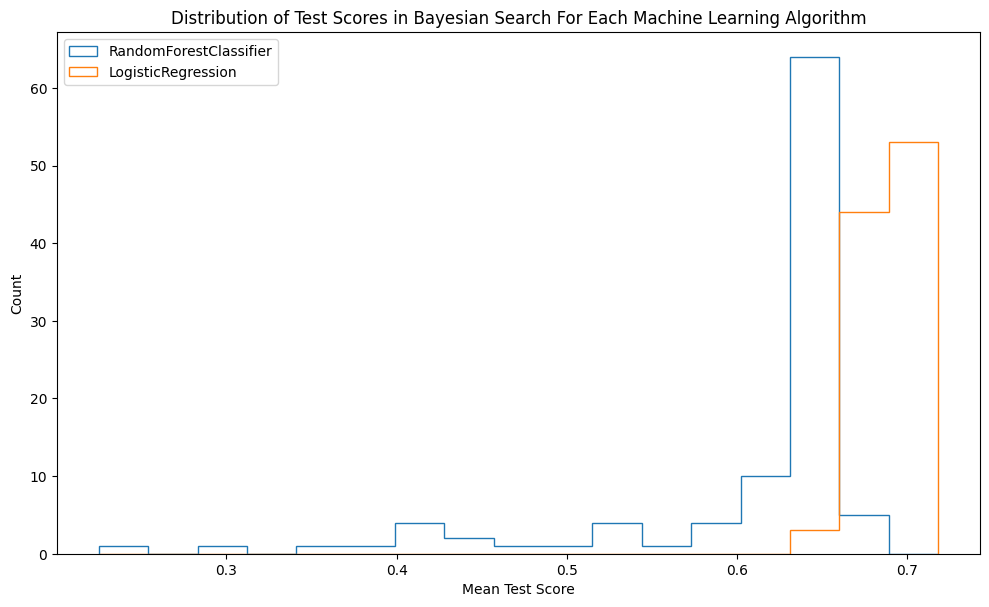

In [421]:
df = pd.read_csv('../outputs/prototype/stats/Cummulative_Results_BayesSearchCV.csv', index_col=0)



df['params'] = df['params'].apply(string_to_dict)

best_bw = bestbandwidth(df['mean_test_score'].values)
maxX = df['mean_test_score'].max()
minX = df['mean_test_score'].min()
nBins = int((maxX - minX)/best_bw)
bins = np.linspace(minX, maxX, nBins)
fig, ax = plt.subplots(figsize=[10, 10/1.62])
for algorithm in df['ML_model'].unique():
    ax.hist(df[df['ML_model'] == algorithm]['mean_test_score'], label=algorithm, bins=bins, histtype='step')
ax.set_xlabel("Mean Test Score")
ax.set_ylabel("Count")
ax.set_title("Distribution of Test Scores in Bayesian Search For Each Machine Learning Algorithm")
ax.legend()
fig.tight_layout()

In [422]:
import pickle as pkl
with open('../outputs/prototype/stats/best_model.pkl', 'rb') as f:
    model = pkl.load(f)


In [430]:
model

LogisticRegression(C=1.5028080650031657e-05)

In [433]:
df = pd.read_csv('../outputs/prototype/stats/Cummulative_Results_BayesSearchCV.csv', index_col=0)
df.sort_values('mean_test_score').iloc[-1]

mean_fit_time                                                       0.157134
std_fit_time                                                        0.034329
mean_score_time                                                     0.003571
std_score_time                                                      0.000542
param_bootstrap                                                          NaN
param_class_weight                                                       NaN
param_criterion                                                          NaN
param_max_depth                                                          NaN
param_max_features                                                       NaN
param_min_samples_leaf                                                   NaN
param_min_samples_split                                                  NaN
param_n_estimators                                                       NaN
params                     OrderedDict([('C', 1.5028080650031657e-05), ('...